In [90]:
import graspy as gp
import glob
import os, sys
import numpy as np
import pandas as pd
import multiprocessing as multiproc
import dask
from dask.distributed import Client, progress
import dask.dataframe as ddf
from scipy.stats import mannwhitneyu
from matplotlib.pyplot import savefig

In [9]:
dpath = '/data/hcp/dmri/'
def get_sub(fname):
    stext = os.path.basename(fname).split('_')
    return('{}_{}'.format(stext[0], stext[1]))

dmri_dict = {}
for f in glob.glob(os.path.join(dpath, '*.edgelist')):
    gr_dat = gp.utils.import_edgelist(f)
    if gr_dat.shape == (70, 70):
        dmri_dict[get_sub(f)] = gr_dat
dmri_ar = np.dstack(list(dmri_dict.values()))

/home/eric/.virtualenvs/graspy/lib/python3.7/site-packages/graspy-0.2.0-py3.7.egg/graspy/utils/utils.py:149: UserWarning: All graphs have 0 vertices. Please double check if proper 'delimiter' is given.
  warnings.warn(msg, UserWarning)
/home/eric/.virtualenvs/graspy/lib/python3.7/site-packages/graspy-0.2.0-py3.7.egg/graspy/utils/utils.py:149: UserWarning: All graphs have 0 vertices. Please double check if proper 'delimiter' is given.
  warnings.warn(msg, UserWarning)


In [52]:
fpath = '/data/hcp/fmri/'
def get_sub(fname):
    stext = os.path.basename(fname).split('_')
    return('{}_{}'.format(stext[0], stext[1]))

fmri_dict = {}
for f in glob.glob(os.path.join(fpath, '*.edgelist')):
    gr_dat = gp.utils.import_edgelist(f)
    if gr_dat.shape == (70, 70):
        fmri_dict[get_sub(f)] = gr_dat
fmri_ar = np.dstack(list(fmri_dict.values()))

In [53]:
ncores = 6
client = Client(threads_per_worker=1, n_workers=ncores)
client

/home/eric/.virtualenvs/graspy/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44267 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:42563 Dashboard: http://127.0.0.1:44267/status,Cluster Workers: 6 Cores: 6 Memory: 33.51 GB


In [54]:
def modular_edges(n):
    """
    A function for generating modular sbm edge communities.
    """
    m = int(n/2)
    edge_comm = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if ( (i<m) & (j<m)) or ( (i>=m ) & (j>=m) ):
                edge_comm[i,j] = 1
            else:
                edge_comm[i,j] = 2   
    return edge_comm

def diag_edges(n):
    """
    A function for generating diagonal SIEM edge communities.
    """
    m = int(n/2)
    edge_comm = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if (i == j + m) or (j == i + m):
                edge_comm[i,j] = 1
            else:
                edge_comm[i,j] = 2
    return edge_comm

def mww(G, C):
    A = G[C == 1]
    B = G[C == 2]
    return(mannwhitneyu(A, B, alternative='two-sided')[1])

In [55]:
def run_exp(row):
    if row[0] == "dMRI":
        A = dmri_dict[row[1]]  # grab connectome using ID
    elif row[0] == "fMRI":
        A = fmri_dict[row[1]]
    test_name = row[2] # grab name of the test
    if test_name == "Homophily":
        C = modular_edges(A.shape[0])
    elif test_name == "Homotopy":
        C = diag_edges(A.shape[0])
    pval = mww(A, C)
    return (row[0], row[1], row[2], pval)

In [56]:
exps = []
for modality in ["dMRI", "fMRI"]:
    if modality == "dMRI":
        conn_dict = dmri_dict
    elif modality == "fMRI":
        conn_dict = fmri_dict
    for key in conn_dict.keys():
        for test in ["Homophily", "Homotopy"]:
            exps.append([modality, key, test])
sim_exps = pd.DataFrame(exps, columns=["Modality", "ID", "Test Name"])
print(sim_exps.head())

  Modality                ID  Test Name
0     dMRI  sub-381543_ses-1  Homophily
1     dMRI  sub-381543_ses-1   Homotopy
2     dMRI  sub-205826_ses-1  Homophily
3     dMRI  sub-205826_ses-1   Homotopy
4     dMRI  sub-206828_ses-1  Homophily


In [57]:
sim_exps = ddf.from_pandas(sim_exps, npartitions=ncores*1.5)
sim_results = sim_exps.apply(lambda x: run_exp(x), axis=1, result_type='expand',
                             meta={0: str, 1: str, 2: str, 3: float})
sim_results

,0,1,2,3
npartitions=9,,,,
0,object,object,object,float64
417,...,...,...,...
...,...,...,...,...
3336,...,...,...,...
3745,...,...,...,...


In [58]:
sim_results = sim_results.compute(scheduler="multiprocessing")
sim_results = sim_results.rename(columns={0: "Modality", 1: "ID", 2: "Test Name", 3: "p_val"})
sim_results.to_csv('./data/hcp_singlegraph_results.csv')

In [59]:
np.savetxt('./data/hcp_dmri_avg.csv', dmri_ar.mean(axis=2), delimiter=',')
np.savetxt('./data/hcp_fmri_avg.csv', fmri_ar.mean(axis=2), delimiter=',')

In [61]:
sim_results

,Modality,ID,Test Name,p_val
0,dMRI,sub-381543_ses-1,Homophily,5.505558e-98
1,dMRI,sub-381543_ses-1,Homotopy,4.790909e-07
2,dMRI,sub-205826_ses-1,Homophily,4.126077e-87
3,dMRI,sub-205826_ses-1,Homotopy,2.126401e-08
4,dMRI,sub-206828_ses-1,Homophily,6.652131e-124
...,...,...,...,...
3741,fMRI,sub-158540_ses-1,Homotopy,1.304032e-01
3742,fMRI,sub-153732_ses-1,Homophily,5.224379e-12
3743,fMRI,sub-153732_ses-1,Homotopy,7.667613e-01
3744,fMRI,sub-465852_ses-1,Homophily,9.124389e-03


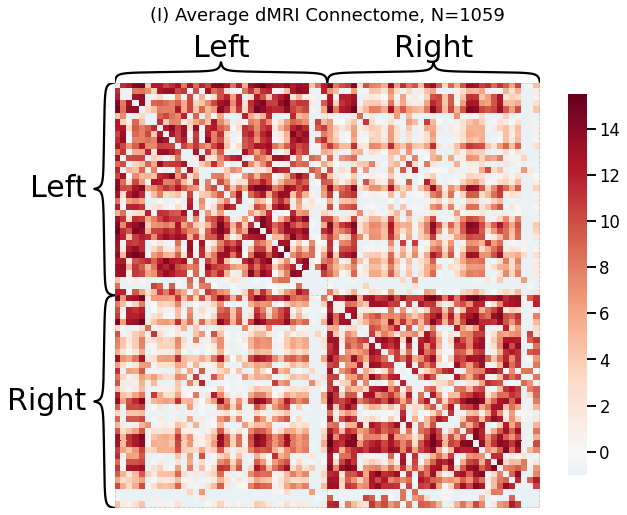

In [91]:
dmri_conn = gp.plot.heatmap(np.log2(dmri_ar.mean(axis=2) + .5), title="(I) Average dMRI Connectome, N=1059", inner_hier_labels=["Right" if i > 35 else "Left" for i in range(1, 71)])
savefig('./hcp_dmri.svg', format='svg')